# Importing necesarry libraries.


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import pathlib
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Exploring the dataset.


In [2]:
index = 0
data_path = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'

# Storing all the labels(Which are also the subdirectories) in the form of a list.
paths = [os.path.join(data_path, name) for name in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, name))]
#Storing all the labels in a list.
labell = []
for path in paths:
    label = path.split("/")[-1]  # Split the path by "/" and access the second-to-last element
    labell.append(label)

print(labell)

['N', 'R', 'space', 'B', 'I', 'del', 'F', 'H', 'E', 'U', 'M', 'X', 'K', 'Q', 'Y', 'S', 'G', 'A', 'O', 'T', 'V', 'Z', 'C', 'P', 'L', 'W', 'D', 'nothing', 'J']


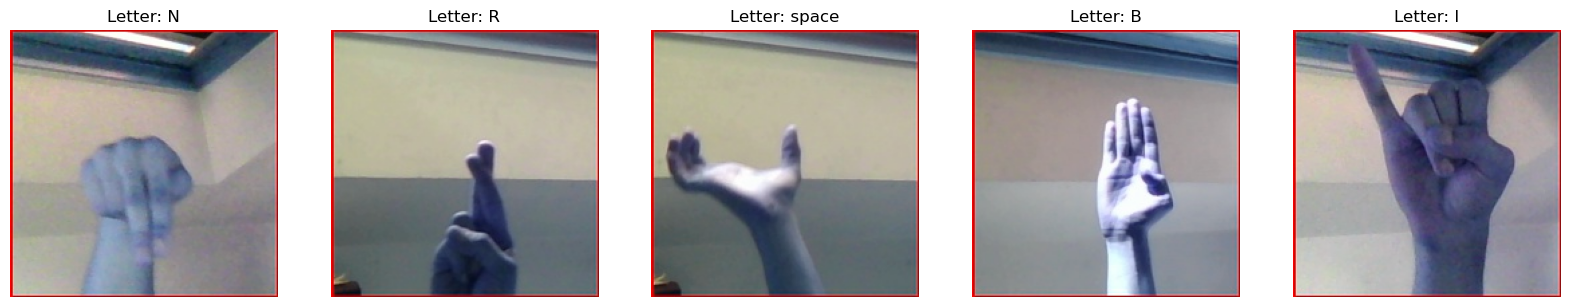

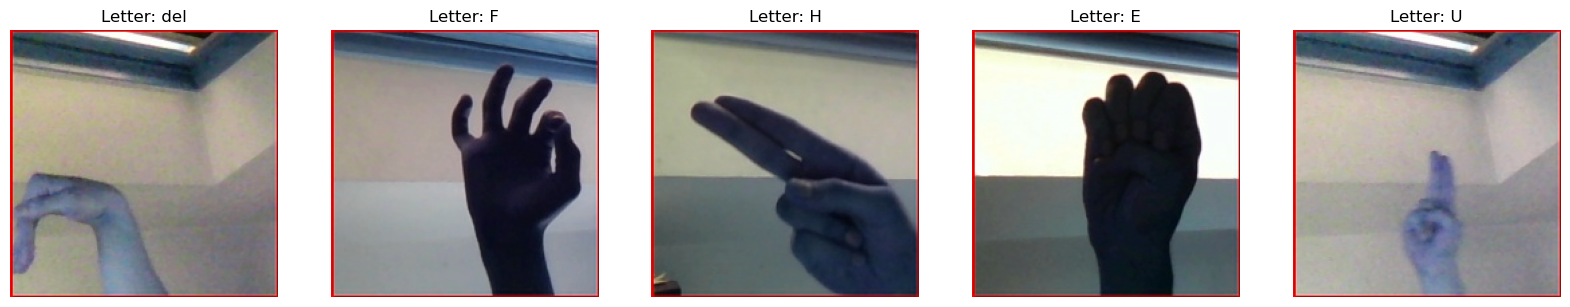

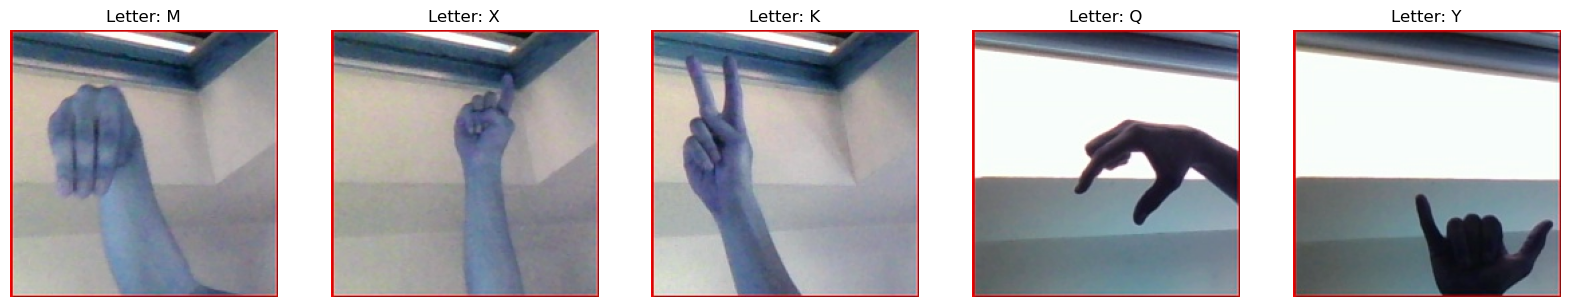

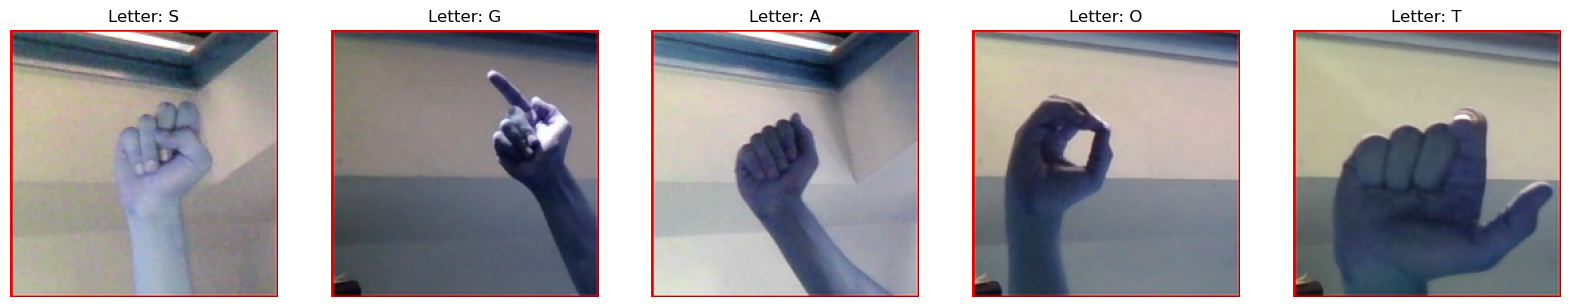

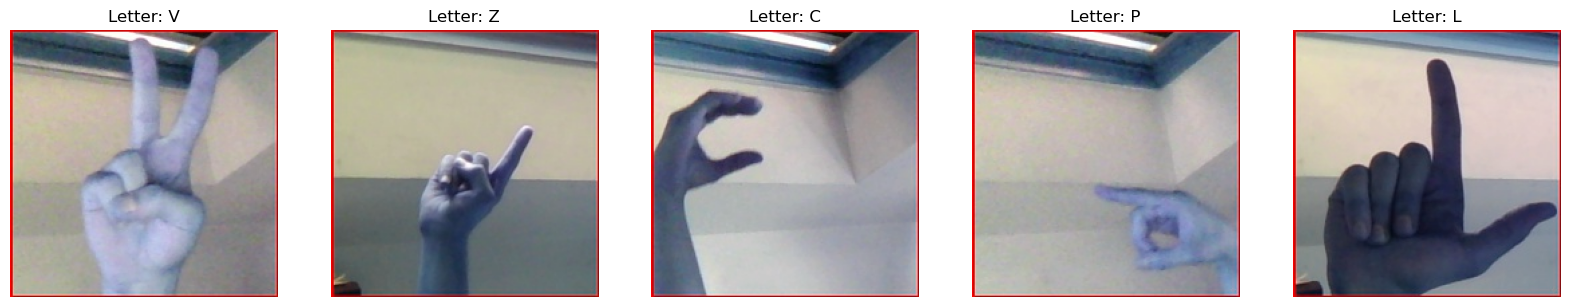

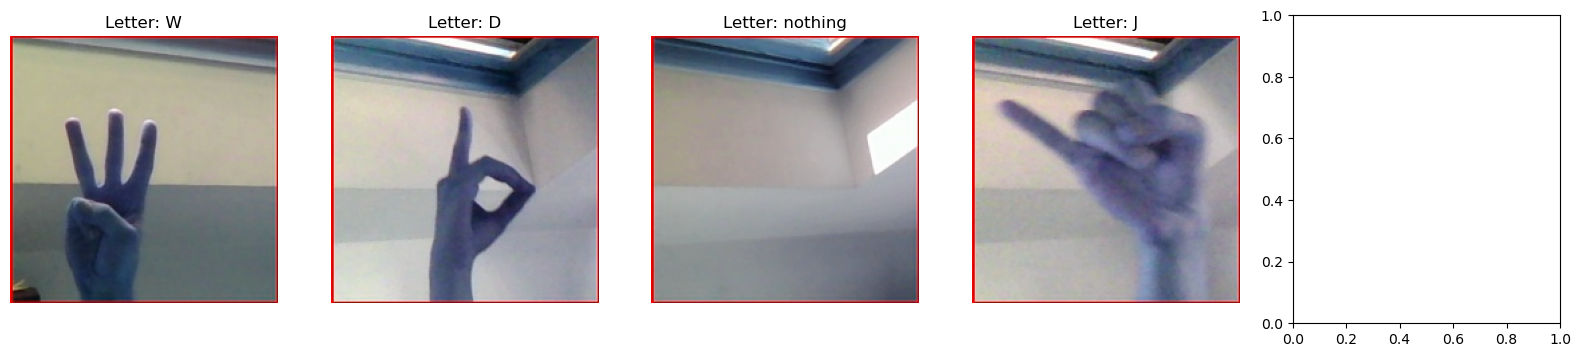

In [3]:
images_per_row = 5
num_images = len(paths)

for i in range(0, num_images, images_per_row):
    fig, axes = plt.subplots(1, images_per_row, figsize=(20, 4))
    
    for j in range(images_per_row):
        idx = i + j
        if idx < num_images:
            subdir = paths[idx]
            image_files = os.listdir(subdir)
            if image_files:
                image_path = os.path.join(subdir, image_files[0])
                image = cv2.imread(image_path)
                folder_name = os.path.basename(subdir)
                
                axes[j].imshow(image)
                axes[j].set_title(f'Letter: {folder_name}')
                axes[j].axis('off')
    
    plt.show()

**Making a pandas dataframe of paths and labels**

In [4]:
files_path = []
files_labels = []

for root, dirs, files in os.walk(data_path):
    p = pathlib.Path(root)
  
    for file in files:
        files_path.append(root + '/' + file)
        files_labels.append(p.parts[-1])
        
len(files_path), len(files_labels)

import pandas as pd 

df = pd.DataFrame(list(zip(files_labels,files_path)),
               columns =['labels', 'image'])
df.head()

,labels,image
0,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
1,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
2,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
3,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
4,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...


In [5]:
x_train,x_test = train_test_split(df, test_size= 0.2, random_state=42)

N 3000
R 3000
space 3000
B 3000
I 3000
del 3000
F 3000
H 3000
E 3000
U 3000
M 3000
X 3000
K 3000
Q 3000
Y 3000
S 3000
G 3000
A 3000
O 3000
T 3000
V 3000
Z 3000
C 3000
P 3000
L 3000
W 3000
D 3000
nothing 3000
J 3000


<BarContainer object of 29 artists>

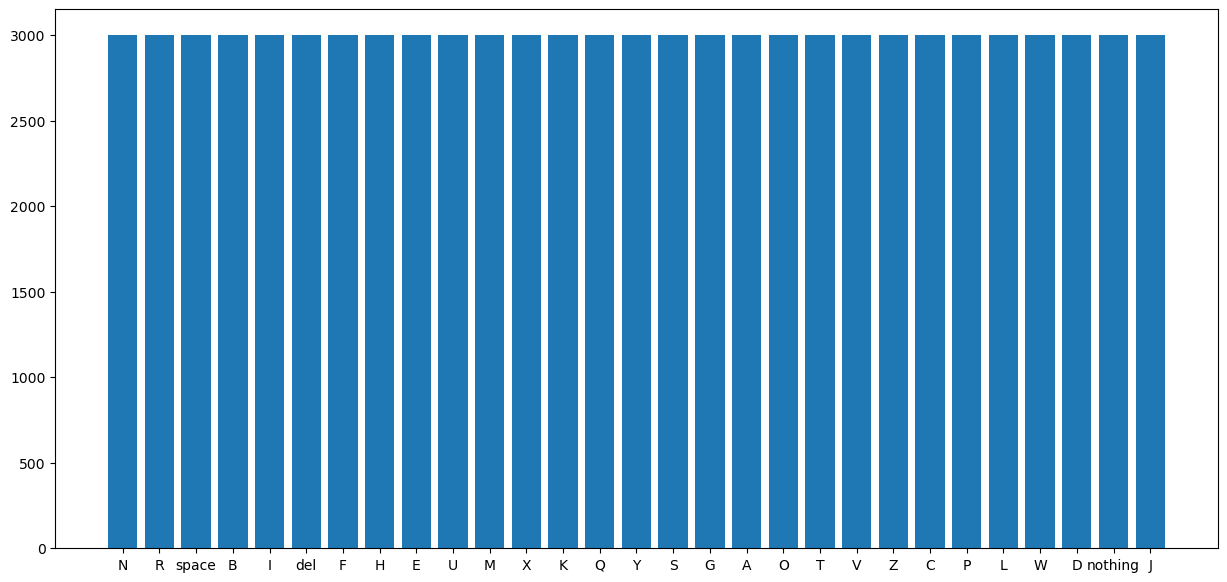

In [6]:
label_count = []
for label in labell:
  print(label, files_labels.count(label))
  label_count.append(files_labels.count(label))
    
#Plotting a label vs label_count graph.
plt.figure(figsize=(15, 7))
plt.bar(labell, label_count)

# Data Preprocessing using ImageDataGenerator


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to the data directory

# Set batch size and image dimensions
batch_size = 300
image_size = (100, 100)  # Adjust the dimensions to match your image size
x_column = 'image'
y_column = 'labels'

# Create a data generator with data augmentation and splitting
data_generator = ImageDataGenerator(
    rescale=1.0 / 255,  # Rescale pixel values to [0, 1]
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15, 
    horizontal_flip=True,
)

# Create a data generator
data_generator_flow = data_generator.flow_from_dataframe(
    x_train,
    x_col = x_column,
    y_col = y_column,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  
    color_mode = 'grayscale',
    shuffle=False,
)

validation_generator_flow = data_generator.flow_from_dataframe(
    x_test,
    x_col = x_column,
    y_col = y_column,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode = 'grayscale',
    shuffle=False,
)


Found 69600 validated image filenames belonging to 29 classes.
Found 17400 validated image filenames belonging to 29 classes.


# Training the Model

In [8]:
model = Sequential()
model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(100, 100, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(.2))
model.add(Conv2D(128, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(.2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(.2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(29, activation='softmax'))  
model.summary()

# Compile the model
model.compile(optimizer= Adam(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])

#callbacks
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=3)
tensorboard_callback = TensorBoard(log_dir='logs', histogram_freq=1)
model_checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


# Train the model
model.fit(data_generator_flow, epochs = 15, validation_data = validation_generator_flow, callbacks =[early_stopping_callback, tensorboard_callback, model_checkpoint_callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 128)       204928    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 22, 22, 128)       0

2023-08-07 11:41:47.642162: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


232/232 [==============================] - 512s 2s/step - loss: 2.7120 - accuracy: 0.2046 - val_loss: 1.6648 - val_accuracy: 0.5029
Epoch 2/15
232/232 [==============================] - 210s 905ms/step - loss: 1.4870 - accuracy: 0.5221 - val_loss: 0.9451 - val_accuracy: 0.7202
Epoch 3/15
232/232 [==============================] - 216s 930ms/step - loss: 1.0225 - accuracy: 0.6600 - val_loss: 0.5837 - val_accuracy: 0.8252
Epoch 4/15
232/232 [==============================] - 213s 919ms/step - loss: 0.7791 - accuracy: 0.7366 - val_loss: 0.4382 - val_accuracy: 0.8697
Epoch 5/15
232/232 [==============================] - 214s 920ms/step - loss: 0.6244 - accuracy: 0.7873 - val_loss: 0.3097 - val_accuracy: 0.9094
Epoch 6/15
232/232 [==============================] - 216s 930ms/step - loss: 0.5209 - accuracy: 0.8212 - val_loss: 0.2450 - val_accuracy: 0.9280
Epoch 7/15
232/232 [==============================] - 213s 920ms/step - loss: 0.4507 - accuracy: 0.8464 - val_loss: 0.1969 - val_accuracy:

# Plotting Accuracy and Loss graphs


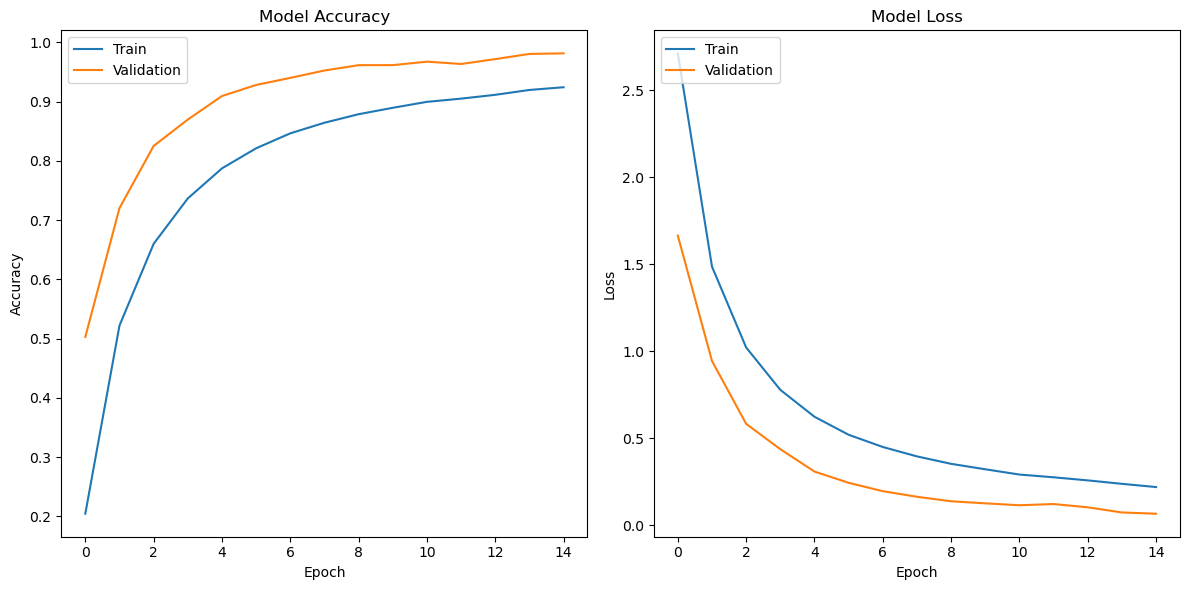

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()